In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import string # for punctuation
import plotly.graph_objs as go
from plotly import subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import os
import nltk
from scipy.sparse import hstack
import pickle
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def contain_model(loc):
    return os.path.exists(loc)

BASE_PATH = "/content/gdrive/My Drive/ml-phase2/"

#Data

In [31]:
train_dataset = pd.read_csv(BASE_PATH + "sarcasm_train_set.csv")
test_dataset = pd.read_csv(BASE_PATH + "sarcasm_test_set.csv")

sarcasm_df = train_dataset[train_dataset["label"]==1]
natural_df = train_dataset[train_dataset["label"]==0]

In [23]:
train_dataset.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?


In [24]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808998 entries, 0 to 808997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      808998 non-null  int64 
 1   label           808998 non-null  int64 
 2   comment         808960 non-null  object
 3   author          808998 non-null  object
 4   subreddit       808998 non-null  object
 5   score           808998 non-null  int64 
 6   ups             808998 non-null  int64 
 7   downs           808998 non-null  int64 
 8   date            808998 non-null  object
 9   created_utc     808998 non-null  object
 10  parent_comment  808998 non-null  object
dtypes: int64(5), object(6)
memory usage: 67.9+ MB


# Preprocessing

Before any thing we need preprocess texts:
- remove stop words ( words like: and, I, you ) which are used very regularly
- remove puncuation marks
- lower case texts
- stemming
- lemmatization


The idea of **lemmatization** is to bring a wird to it's base form, for example: "seen => see", "drove => drive". The situation here is the same as with stemming,even more tricky. We need to write tokenizer here and strip the punctuation manually, but finally it works.

**Stemming** cuts the ending of the word like this "house, houses, house’s, houses’ => house". 


In [25]:
def preprocess(dataset, loc):
    if contain_model(loc):
    dataset = pd.read_csv(loc)
    else:
    dataset.dropna(subset=['comment'], inplace=True)
    dataset = lower_case(dataset)
    dataset = remove_stop_words(dataset)
    dataset = stemming(dataset)
    dataset = lemma(dataset)
    dataset = remove_puncuation(dataset)

    dataset.replace("", float("NaN"), inplace=True)
    dataset.dropna(inplace=True)
    dataset.to_csv(loc)

    return dataset
    
def lower_case(dataset):    
    dataset['comment'] = dataset['comment'].str.lower()
    dataset['parent_comment'] = dataset['parent_comment'].str.lower()
    return dataset
        
def remove_puncuation(dataset):
    def rm_punc(text: str):
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
        return text
    
    dataset['comment'] = dataset['comment'].apply(rm_punc)
    dataset['parent_comment'] = dataset['parent_comment'].apply(rm_punc)
    return dataset

def remove_stop_words(dataset):
    def rm_sw(text):
        return ' '.join([word for word in text.split() if word not in (STOPWORDS)])
    
    dataset['comment'] = dataset['comment'].apply(rm_sw)
    dataset['parent_comment'] = dataset['parent_comment'].apply(rm_sw)
    return dataset

def stemming(dataset):
    def stem(text):
        return ' '.join([stemmer.stem(word) for word in text.split()])
  
    stemmer = PorterStemmer()
    dataset['comment'] = dataset['comment'].apply(stem)
    dataset['parent_comment'] = dataset['parent_comment'].apply(stem)
    return dataset

def lemma(dataset):
    def l(text):
        return ' '.join([wnl.lemmatize(word, wordnet.VERB) for word in word_tokenize(text)])

    wnl = WordNetLemmatizer()
    dataset['comment'] = dataset['comment'].apply(l)
    dataset['parent_comment'] = dataset['parent_comment'].apply(l)
    return dataset

In [77]:
train_dataset = preprocess(train_dataset, BASE_PATH + "train_processed.csv")
test_dataset = preprocess(test_dataset, "test_processed.csv")

In [78]:
data_train = train_dataset
data_test = test_dataset

In [19]:
train_dataset.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?


# EDA

In [10]:
row, col = train_dataset.shape
print("There are", row, "and", col, "columns for train data")

There are 808998 and 11 columns for train data


We can see that the maximum values of score and ups are very high, but the maximum of downs is only 0. Likewise, the minimum values for score and ups get very low to -507, but the minimum for downs is only -1. <br>

Curiously, we can also see that the maximum of score does not equal the maximum of ups. From the 25th and 75th percentile values, we can determine that half of the data is at or between the values of 0 and 4. Since the minimum and maximum are quite far from this range, this means that the distribution of the scores is likely to be very skewed

In [33]:
train_dataset.describe()

,Unnamed: 0,label,score,ups,downs
count,8.089980e+05,808998.000000,808998.000000,808998.000000,808998.000000
mean,5.053423e+05,0.500333,6.895280,5.493865,-0.145936
std,2.917874e+05,0.500000,48.624648,40.947984,0.353042
min,0.000000e+00,0.000000,-507.000000,-507.000000,-1.000000
25%,2.525642e+05,0.000000,1.000000,0.000000,0.000000
50%,5.052075e+05,1.000000,2.000000,1.000000,0.000000
75%,7.580998e+05,1.000000,4.000000,3.000000,0.000000
max,1.010825e+06,1.000000,9070.000000,5163.000000,0.000000


So what does this investigation of negative ups and downs tell us? Well, it tells me that the ups and downs columns seem unreliable. Since there is no explanation for what these columns mean on either the Kaggle page for this dataset or in the paper by the authors, we may want to consider not including these columns in our future models.

In [34]:
i = train_dataset["ups"].idxmin()
train_dataset.loc[i, :]

Unnamed: 0                                                   305117
label                                                             1
comment           yes...the smiling is irrelevant when trying to...
author                                                     Grippler
subreddit                                                       aww
score                                                          -507
ups                                                            -507
downs                                                             0
date                                                        2016-07
created_utc                                     2016-07-16 14:33:06
parent_comment    She did the happy dance! Thats how you know sh...
Name: 244361, dtype: object

This figure ensures that the dataset is balanced as the proportion of the sarcastic and non-sarcastic comments are same i.e.- 50%


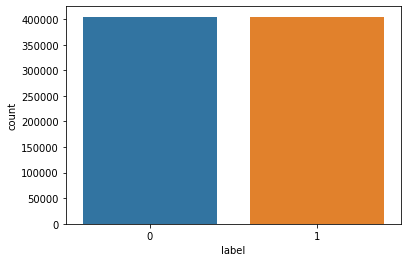

In [13]:
ax = sns.countplot(x='label',  data=train_dataset) 
plt.show()

## Word Cloud of sarcasm comments

Lets try to show word coloud of comments:

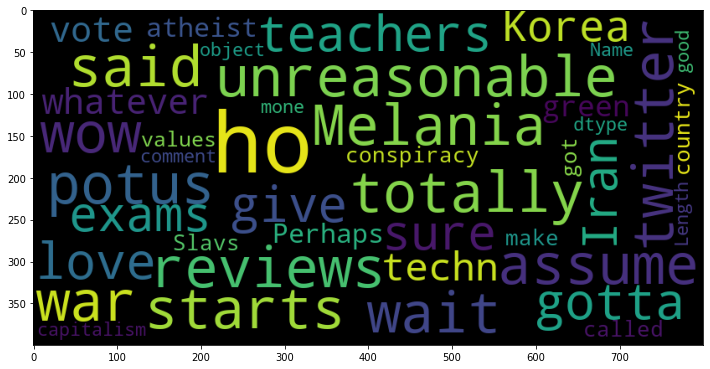

In [14]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(train_dataset.loc[train_dataset['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

## Most frequent tokens

Now we show most frequent tokens in unigram, bigram, and trigrams for both classes:

In [35]:
def generate_ngrams(text, n_gram=1):
    token = [
        token.strip(string.punctuation)         # remove punctuation
        for token in text.lower().split(" ")    # for words in text; lower cased
            if token.strip(string.punctuation) != ""
                 if token not in STOPWORDS      # except empty and stop words
    ] 
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def get_frequent_tokens(df, count, n_gram):
    ## Get the bar chart from insincere questions ##
    freq_dict = defaultdict(int)
    for comment in  df["comment"]:
        for word in generate_ngrams(comment, n_gram):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    return fd_sorted.head(count)

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace



In [103]:
## Get the bar chart from natural comments ##
natural_df = train_dataset[train_dataset["label"]==0]
freq_tokens = get_frequent_tokens(natural_df, 30, 1)
trace0 = horizontal_bar_chart(freq_tokens, 'blue')

## Get the bar chart from sarcasm comments ##
sarcasm_df = train_dataset[train_dataset["label"]==1]
freq_tokens = get_frequent_tokens(sarcasm_df, 30, 1)
trace1 = horizontal_bar_chart(freq_tokens, 'red')

# Creating two subplots
fig = subplots.make_subplots(
    rows=1, cols=2, vertical_spacing=0.04,
    subplot_titles=["Frequent words of natural comments", "Frequent words of sarcasm comments"]
)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=700, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

In [35]:
# BIGRAMS
## Get the bar chart from natural comments ##
freq_tokens = get_frequent_tokens(natural_df, 30, 2)
trace0 = horizontal_bar_chart(freq_tokens, 'blue')

## Get the bar chart from sarcasm comments ##
freq_tokens = get_frequent_tokens(sarcasm_df, 30, 2)
trace1 = horizontal_bar_chart(freq_tokens, 'red')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of natural comments", 
                                          "Frequent bigrams of sarcasm comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=700, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [35]:
# TRIGRAMS
## Get the bar chart from natural comments ##
freq_tokens = get_frequent_tokens(natural_df, 30, 3)
trace0 = horizontal_bar_chart(freq_tokens, 'blue')

## Get the bar chart from sarcasm comments ##
freq_tokens = get_frequent_tokens(sarcasm_df, 30, 3)
trace1 = horizontal_bar_chart(freq_tokens, 'red')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent Trigrams of natural comments", 
                                          "Frequent Trigrams of sarcasm comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=700, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

Results:
- 'oh', 'realy', 'obviously' -> sarcasm 
- 'good thing', 'everyone knows' -> sarcasm
- Many combinations -> for both sarcasm and non-sarcasm


## Score

** **Distribution of Log Scores for Sarcastic and Non-Sarcastic :** **

In this histogram, I zoom in to the score range of -7.5 to +7.5 because we have very long, thin tails in the distribution of scores. The distributions of scores for sarcastic and non-sarcastic comments seem to be very similar, but we can see that sarcastic comments are slightly more likely to get negative scores, while non-sarcastic comments are slightly more likely to get scores in the 1 to 3 range.

Text(0.5, 1.0, 'LogBase10-Scores for Sarcastic vs. None-Sarcastic Comments')

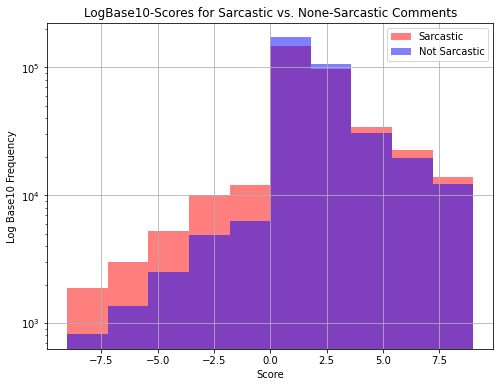

In [38]:
plt.figure(figsize=(8,6))
df = train_dataset.copy()
mean = df['score'].mean()
std = df['score'].std()

df[(df['score'].abs()<(10-((df['score'].abs()-mean)/std))) & (df['label']==1)]['score'].hist(alpha=0.5,label='Sarcastic', color = 'red')
df[(df['score'].abs()<(10-((df['score'].abs()-mean)/std))) & (df['label']==0)]['score'].hist(alpha=0.5,label='Not Sarcastic', color = 'blue')
plt.yscale('log')
plt.ylabel('Log Base10 Frequency')
plt.xlabel('Score')
plt.legend()
plt.title('LogBase10-Scores for Sarcastic vs. None-Sarcastic Comments')

 ** **Distribution of ups for Sarcastic and Non-Sarcastic Comments:** **


As the previous part, in this histogram, I zoom in to the score range of -7.5 to +7.5. We can see that sarcastic comments are slightly more likely to larger absolute ups, while non-sarcastic comments are slightly more likely to get ups in the -2 to 3 range.

Text(0.5, 1.0, 'LogBase10-ups for Sarcastic vs. None-Sarcastic Comments')

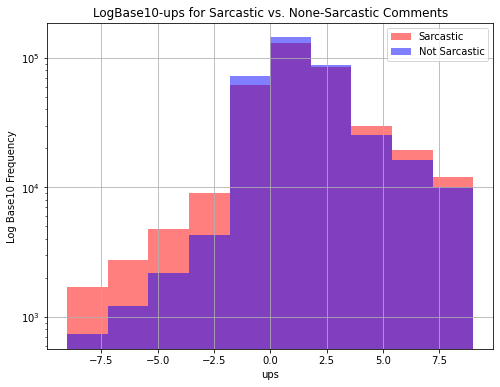

In [39]:
plt.figure(figsize=(8,6))
mean = df['ups'].mean()
std = df['ups'].std()


df[(df['ups'].abs()<(10-((df['ups'].abs()-mean)/std))) & (df['label']==1)]['ups'].hist(alpha=0.5,label='Sarcastic', color = 'red')
df[(df['ups'].abs()<(10-((df['ups'].abs()-mean)/std))) &(df['label']==0)]['ups'].hist(alpha=0.5,label='Not Sarcastic', color = 'blue')
plt.yscale('log')
plt.ylabel('Log Base10 Frequency')
plt.xlabel('ups')
plt.legend()
plt.title('LogBase10-ups for Sarcastic vs. None-Sarcastic Comments')

## parent comments VS comments

In [79]:
comm_len = np.array(train_dataset['comment'].str.len())
parent_comm_len = np.array(train_dataset['parent_comment'].str.len())
ratio_len = np.array((train_dataset['comment'].str.len())/(train_dataset['parent_comment'].str.len()))

df = pd.DataFrame( {
    'label': train_dataset['label'],
    'Comment Length': comm_len,
    'Parent Comment Length': parent_comm_len,
    'Ratio Length': ratio_len
    }, columns=['label','Comment Length', 'Parent Comment Length', 'Ratio Length']
)

According to the below visual, we can conclude that in most of the cases; the length of the sarcastic comments is longer than their corresponding parent comments. and most of scarsam comment have lower size than natural comments

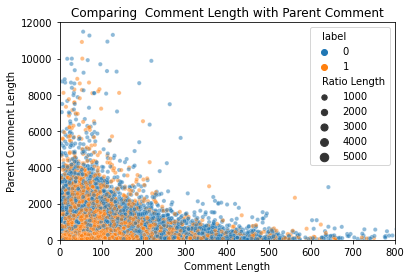

In [41]:
ax = plt.axes()
sns.scatterplot(data=df, x="Comment Length", y="Parent Comment Length",size="Ratio Length", hue='label', alpha=0.5)
ax.set_title("Comparing  Comment Length with Parent Comment")
# control x and y limits
plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

## SubReddits

Lets show top 10 subredits 

In [80]:
top_reddits = list(train_dataset['subreddit'].value_counts()[:10].keys())

In [81]:
train_dataset[train_dataset["subreddit"].isin(top_reddits)].groupby("subreddit").agg({"label" : "mean"})

,label
subreddit,
AskReddit,0.403072
funny,0.453875
leagueoflegends,0.547077
news,0.600963
nfl,0.504654
pcmasterrace,0.568179
pics,0.487136
politics,0.605848
todayilearned,0.551382


Here we can see that some subreddits seem much more sarcastic than others. The `worldnews` subreddit is highest among these with 64% sarcasm, whereas `AskReddit` is lowest with 40%. 

Based on this data, can we conclude that worldnews and atheism are among the most sarcastic subreddits on the site? Is it true that if we logged on and picked a random post on r/worldnews, we would have a 64% chance of getting a sarcastic one? The correct answer is no, to both questions.

The reasoning lies in the fact that this dataset is taken from a sample of reddit comments. Not only that, but in order to create this balanced dataset, the authors even further sampled the data to even out the classes. In their paper, the authors state that in their original sample of comments, only 1% were sarcastic. Since this dataset has been manipulated in this way, it gives us a skewed view of comments and subreddits.

## Date

For our next visualization, let's see if the amount of sarcastic comments varies over time

Interesting, the percentage of sarcastic comments jumps around a bit, but tends to decrease as time goes on.

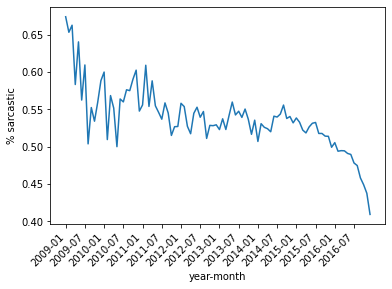

In [46]:
by_month = train_dataset.groupby("date").agg({"label" : "mean", "comment" : "count"})
months = list(by_month.index)
label_pos = list(range(0, len(months), 6))
m_labels = [months[i] for i in label_pos]

plt.plot(months, by_month["label"])
plt.xlabel("year-month")
plt.ylabel("% sarcastic")
plt.xticks(label_pos, m_labels, rotation=45, ha="right")
plt.show()

Indeed, we see a large ramp up in the number of comments as time goes on. There are far more comments for 2015 and 2016 than there are before 2014. This reveals an interesting piece of information: as the number of comments increased over time, the percentage of sarcastic comments per month decreased.

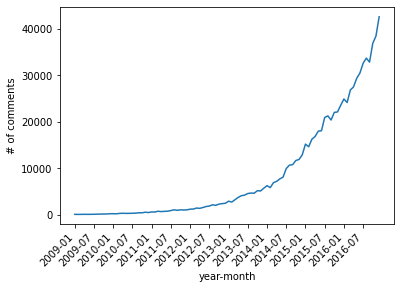

In [47]:
months = list(by_month.index)
label_pos = list(range(0, len(months), 6))
m_labels = [months[i] for i in label_pos]

plt.plot(months, by_month["comment"])
plt.xlabel("year-month")
plt.ylabel("# of comments")
plt.xticks(label_pos, m_labels, rotation=45, ha="right")
plt.show()

Why would that be? My assumption is that though the label classes are balanced over the entire dataset, the authors did not bother to balance them over time, and possibly also not over other variables. Perhaps that was just difficult to do, but it reveals that using date as a feature in our models would cause them to base predictions on false trends.

Does that mean that date is entirely useless to us? Maybe not. We may be able to utilize some information from it if we tinker with it a bit, which brings us to our next step: Feature Engineering.

# Normalization & Feature Engineering

We can define some new features and investigate them.
I'll add features `score_negative`, `has_downvote`, `score_negative`, `downvotes_more`, `upvotes_more3`, `commment_length`!

Moreover, we break created_utc to `year`, `month`, `day` and `hour` and `day of week`.

In [82]:
def feature_engineering(dataset):
    #score
    dataset["score_negative"] = dataset["score"] < 0
    dataset["has_downvote"] = dataset["downs"] == -1
    dataset["downvotes_more"] = dataset['downs'].abs() >= dataset['ups'].abs()
    dataset["upvotes_more3"] = dataset['ups'] >= 3
    #time
    dataset.created_utc = pd.to_datetime(dataset.created_utc)
    dataset['timestamp'] = dataset["created_utc"].values.astype(np.int64) // 10 ** 9
    dataset['year'] = dataset.created_utc.dt.year
    dataset['month'] = dataset.created_utc.dt.month
    dataset['day'] = dataset.created_utc.dt.day
    dataset['hour'] = dataset.created_utc.dt.hour
    dataset['day_of_week'] = dataset['created_utc'].dt.day_name()
    #comment
    dataset['comment_length'] = dataset['comment'].astype(str).apply(lambda text: np.log(len(text)))


    return dataset

train_dataset = feature_engineering(train_dataset)
test_dataset = feature_engineering(test_dataset)

### Scores

Let's investigate these features:<br>
We can see that **if score is negative the post is more inclined to have sarcastic content,** hence we leave it as our feature.

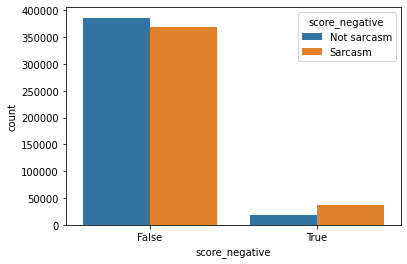

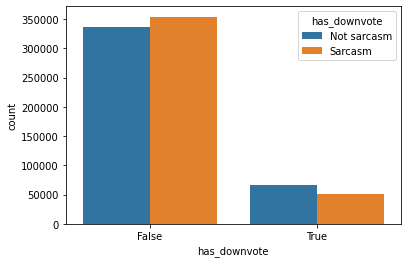

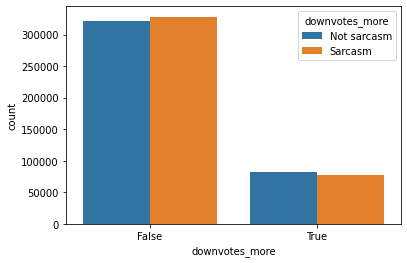

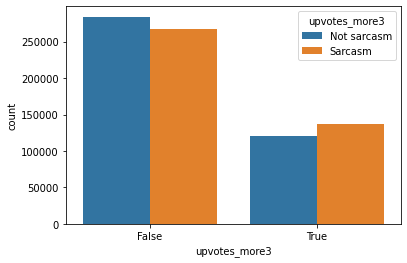

In [49]:
features = ["score_negative", "has_downvote", "downvotes_more", "upvotes_more3"]

for feature in features:
    sns.countplot(x=feature, hue='label', data=train_dataset)
    plt.legend(title=feature, loc='upper right', labels=['Not sarcasm', 'Sarcasm'])
    plt.show()

### Time

New comments are more sarcastic than old one, while the number of comments decreases too.<br>
Moreover, in first hours number of sarcastic comment is lower than other.<br>
 And in the middle of month number of comment decreases!

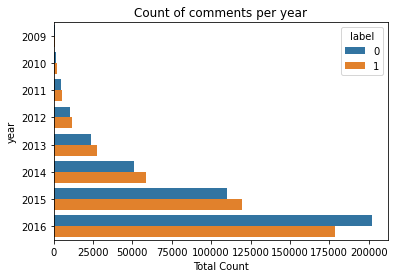

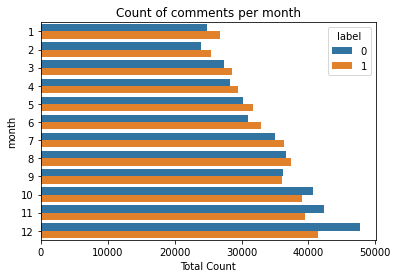

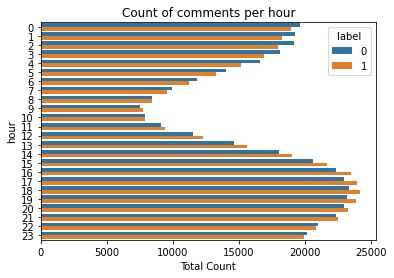

In [50]:
ax = sns.countplot(y='year',  data= train_dataset, hue='label')
ax.set(title = "Count of comments per year", ylabel="year", xlabel = "Total Count")
plt.show()

ax = sns.countplot(y='month',  data= train_dataset, hue='label')
ax.set(title = "Count of comments per month", ylabel="month", xlabel = "Total Count")
plt.show()

ax = sns.countplot(y='hour',  data= train_dataset, hue='label')
ax.set(title = "Count of comments per hour", ylabel="hour", xlabel = "Total Count")
plt.show()


Looks like the portion of sarcastic comments stays fairly constant at 50/50 again, with a slight dip towards non-sarcastic on the weekends. In contrast to the months column we examined above, we can see that the number of comments stays relatively balanced across all the days of the week.



[Text(0, 0.5, 'date'),
 Text(0.5, 0, 'Total Count'),
 Text(0.5, 1.0, 'Count of comments per day')]

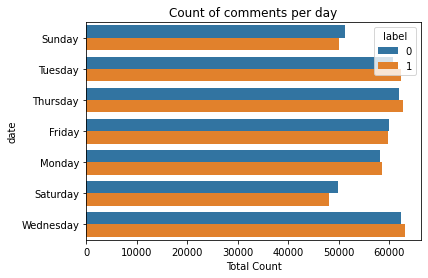

In [51]:
ax = sns.countplot(y='day_of_week',  data= train_dataset, hue='label')
ax.set(title = "Count of comments per day", ylabel="date", xlabel = "Total Count")

### Length of Comments

According to the graph below the lenght of the sarcastic comments is normally distributed where as the non-sarcastic comments is slightly negatively skewed, but they dont have much difference.


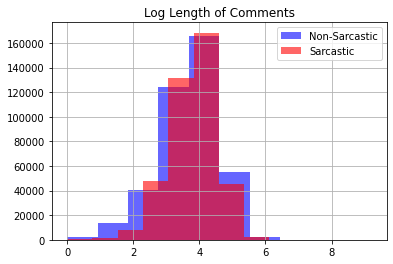

In [52]:
df = train_dataset.copy()
train_dataset[train_dataset['label']==0]['comment_length'].hist(alpha=0.6,label='Non-Sarcastic', color = 'blue')
train_dataset[train_dataset['label']==1]['comment_length'].hist(alpha=0.6,label='Sarcastic', color = 'red')
plt.legend()
plt.title('Log Length of Comments')
plt.show()

## Corrolation

*First*, we should numerize string columns to see their corrolations

In [83]:
def normalize_timestamp(dataset):
    col = dataset["timestamp"]
    dataset["timestamp"] = (col - col.mean()) / (col.max() - col.min())
    return dataset

train_dataset['train'] = 1
test_dataset['train'] = 0
df = train_dataset.append(test_dataset, ignore_index=True)

df['subreddit'] = pd.Categorical(df['subreddit'])
df['subreddit'] = df['subreddit'].cat.codes

df['author'] = pd.Categorical(df['author'])
df['author'] = df['author'].cat.codes

df = normalize_timestamp(df)

train_dataset2 = df[df['train']==1]
test_dataset2 = df[df['train']==0]
    

Lets take a look to corolation map

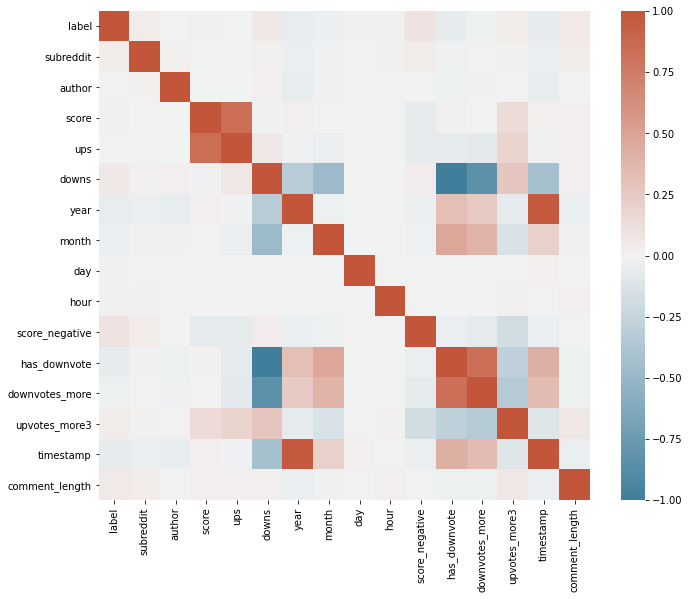

In [84]:
corr = train_dataset2[['label', 'subreddit', 'author',
                    'score', 'ups', 'downs',
                    'year', 'month', 'day', 'hour',
                    "score_negative", "has_downvote", "downvotes_more",
                    "upvotes_more3", "timestamp", "comment_length"
                    ]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

## Features


As we can see in corrolations we just keep `timestamp`, `socre_negative`, `year` and `has_downvote` features.

As you may recall, during data exploration I decided that the `ups` and `downs` columns were unclear and unreliable. Therefore, I will be ommitting them from the model. I will also throw out all of the `auther`, and `parent_comment` column, since the model algorithms have no way to deal with them.

As a result, our training data will consist of the following columns:   `subreddit`, `score_negative`, `has_downvote`, `timestamp`, `comment`.

In [85]:
cols = [
    'subreddit',
    'score_negative',
    'has_downvote',
    'timestamp',
    'comment',
]

train_dataset = normalize_timestamp(train_dataset)
test_dataset = normalize_timestamp(test_dataset)

train_X = train_dataset[cols]
test_X = test_dataset[cols]

train_y = train_dataset["label"]
test_y = test_dataset["label"]


In [86]:
train_X.head()

,subreddit,score_negative,has_downvote,timestamp,comment
0,politics,False,True,0.150579,nc nh
1,nba,True,True,0.155721,know west team play west team east team right
2,nfl,False,False,0.142332,underdog earlier today gronk announc afternoon vega line move patriot 1
3,BlackPeopleTwitter,True,True,0.151223,meme funni none new york nigga one be
4,AskReddit,False,False,0.135326,pay attent her long legal kick bed befor take load


# Embedding

We use embeding techniques below:
- Lemma Vectorizer
- TF-IDF
- Word2Vec


## TF-IDF

Here in tf-idf we set some parameters:
 - Don't use rare words (<20)
 - build bigrams, put a limit on maximal number of features
 -  and minimal word frequency

In [87]:
# ngram_range: unigrams and bigrams,
# min_df: inogre a feature if it is encounter only 20 time
# max_df: inogre a feature if it is encountered too often
tf_idf_text = TfidfVectorizer(ngram_range=(1, 2), min_df=20, max_df=0.7, max_features=50000)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

def reshape(col):
    return col.values.reshape((len(col.values), 1))

def tf_idf(dataset, loc, fit=True):
    if contain_model(loc):
        with open(loc, 'rb') as file:
            X = pickle.load(file)
    else:
        if fit:
            tf_idf_subreddit = tf_idf_subreddits.fit_transform(dataset['subreddit'])
            tf_idf_comment = tf_idf_text.fit_transform(dataset['comment'].astype('U').values)
        else:
            tf_idf_subreddit = tf_idf_subreddits.transform(dataset['subreddit'])
            tf_idf_comment = tf_idf_text.transform(dataset['comment'].astype('U').values)
        score_negative_reshaped = reshape(dataset['score_negative'])
        has_downvote_reshaped = reshape(dataset['has_downvote'])
        ts_reshaped = reshape(dataset['timestamp'])
        X = hstack([
                    tf_idf_comment,
                    tf_idf_subreddit, 
                    score_negative_reshaped.astype(float),
                    has_downvote_reshaped.astype(float),
                    ts_reshaped.astype(float)
                  ])
        with open(loc, 'wb') as file:
            pickle.dump(X, file)
    return X

tf_idf_train_X = tf_idf(train_X, BASE_PATH + "tf_id_train_X.pkl", True)
tf_idf_test_X = tf_idf(test_X, BASE_PATH + "tf_idf_test_X.pkl", False)


##  Bag of Words

In [89]:
from nltk import word_tokenize
from nltk.corpus import wordnet 

count_vectorizer_subredit = CountVectorizer(strip_accents='unicode', min_df=20, max_df=0.7,  max_features=50000) 
count_vectorizer_text = CountVectorizer() 

def reshape(col):
    return col.values.reshape((len(col.values), 1))

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t,wordnet.VERB) for t in word_tokenize(articles)]

def bag_of_words(dataset, loc, fit=True):
    if contain_model(loc):
        with open(loc, 'rb') as file:
            X = pickle.load(file)
    else:
        if fit:
            tf_idf_subreddit = count_vectorizer_subredit.fit_transform(dataset['subreddit'])
            tf_idf_comment = count_vectorizer_text.fit_transform(dataset['comment'].astype('U').values)
        else:
            tf_idf_subreddit = count_vectorizer_subredit.transform(dataset['subreddit'])
            tf_idf_comment = count_vectorizer_text.transform(dataset['comment'].astype('U').values)
        score_negative_reshaped = reshape(dataset['score_negative'])
        has_downvote_reshaped = reshape(dataset['has_downvote'])
        ts_reshaped = reshape(dataset['timestamp'])
        X = hstack([
                  tf_idf_comment,
                  tf_idf_subreddit, 
                  score_negative_reshaped.astype(float),
                  has_downvote_reshaped.astype(float),
                  ts_reshaped.astype(float)
                ])
        with open(loc, 'wb') as file:
             pickle.dump(X, file)
    return X

bag_w_train_X = bag_of_words(train_X, BASE_PATH + "bag_w_train_X.pkl", True)
bag_w_test_X = bag_of_words(test_X, BASE_PATH + "bag_w_test_X.pkl", False)

## Word2Vec

In [90]:
import os
import sys
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.sklearn_api import W2VTransformer

In [91]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    """
     parameters:
         min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
         window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
         size = int - Dimensionality of the feature vectors. - (50, 300)
         sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
         alpha = float - The initial learning rate - (0.01, 0.05)
         min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
         negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
         workers = int - Use these many worker threads to train the model (=faster training with multicore machines)
    """
    model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)



In [92]:
def word2vec(dataset, loc):
    df = dataset.copy()
    if contain_model(loc):
        df = pd.read_csv(loc)
        df.drop(columns=['Unnamed: 0'], inplace=True)
        return df
    else:
        mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec_model)
        df["comment"] = mean_embedding_vectorizer.transform(df['comment'])
        mean_embedding_vectorizer_subreddit = MeanEmbeddingVectorizer(subreddit_w2vec_model)
        df["subreddit"] = mean_embedding_vectorizer_subreddit.transform(df['subreddit'])
        df.to_csv(loc)
        return df

w2vec_model = get_word2vec(
    MySentences(
        train_dataset['comment'].values,
        test_dataset['comment'].values,
    ),
    BASE_PATH + 'w2vmodel'
)

subreddit_w2vec_model = get_word2vec(
    MySentences(
        train_dataset['subreddit'].values,
        test_dataset['subreddit'].values,
    ),
    BASE_PATH + 'subreddit_w2vmodel'
)
 
train_word2vec_df = word2vec(train_X, BASE_PATH + "w2vec_train_X.csv")
test_word2vec_df = word2vec(test_X, BASE_PATH + "w2vec_test_X.csv")



Found /content/gdrive/My Drive/ml-phase2/w2vmodel
Found /content/gdrive/My Drive/ml-phase2/subreddit_w2vmodel


# Model traning  

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import time
from sklearn.metrics import classification_report
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


## 1. Logistic Regression

In [63]:
class Logit:
    def __init__(self):
        self.model = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
    def fit(self, train_x, train_y, loc):
        if contain_model(loc):
            with open(loc, 'rb') as file:
                self.model = pickle.load(file)
        else:
            self.model.fit(train_x, train_y)
            with open(loc, 'wb') as file:
            pickle.dump(self.model, file)

    def predict(self, test_x, test_y):
        pred_y = self.model.predict(test_x)
        print("results:")
        print(classification_report(test_y, pred_y))

** **Logistic Regresion For TF-idf Results:** ** 



In [88]:
logit = Logit()
logit.fit(tf_idf_train_X, train_y, BASE_PATH + "logit_tfid.pkl")
logit.predict(tf_idf_test_X, test_y)

results:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70    100562
           1       0.71      0.66      0.68    100408

    accuracy                           0.69    200970
   macro avg       0.69      0.69      0.69    200970
weighted avg       0.69      0.69      0.69    200970



** **Logistic Regresion for Bag of Words results:** **

In [93]:
logit = Logit()
logit.fit(bag_w_train_X, train_y, BASE_PATH + "logit_bag_w.pkl")
logit.predict(bag_w_test_X, test_y)

results:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69    100562
           1       0.69      0.65      0.67    100408

    accuracy                           0.68    200970
   macro avg       0.68      0.68      0.68    200970
weighted avg       0.68      0.68      0.68    200970



** **Logistic Regresion for Word2Vector results:** **


In [94]:
logit = Logit()
logit.fit(train_word2vec_df, train_y, BASE_PATH + "logit_w2vec.pkl")
logit.predict(test_word2vec_df, test_y)


results:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57    100562
           1       0.55      0.47      0.50    100408

    accuracy                           0.54    200970
   macro avg       0.54      0.54      0.54    200970
weighted avg       0.54      0.54      0.54    200970



## 2. Random Forest

In [95]:
class RandomForest:
    def __init__(self):
        self.model = RandomForestClassifier(
          # n_estimators=200,
          min_samples_leaf=20,
          random_state=31, 
          n_jobs = 4,
          oob_score=True
    )

    def fit(self, train_x, train_y, loc):
        if contain_model(loc):
            with open(loc, 'rb') as file:
                self.model = pickle.load(file)
        else:
            self.model.fit(train_x, train_y)
            with open(loc, 'wb') as file:
                pickle.dump(self.model, file)

    def predict(self, test_x, test_y):
        pred_y = self.model.predict(test_x)
        print("results:")
        print(classification_report(test_y, pred_y))

** **Random Forest For TF-idf Results:** ** 



In [96]:
rf = RandomForest()
rf.fit(tf_idf_train_X, train_y, BASE_PATH + "rand_forest_tfid.pkl")
rf.predict(tf_idf_test_X, test_y)

results:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67    100562
           1       0.67      0.65      0.66    100408

    accuracy                           0.67    200970
   macro avg       0.67      0.67      0.67    200970
weighted avg       0.67      0.67      0.67    200970



** **Random Forest for Bag of Words results:** **

In [97]:
rf = RandomForest()
rf.fit(bag_w_train_X, train_y, BASE_PATH + "rand_forest_bag_w.pkl")
rf.predict(bag_w_test_X, test_y)

results:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68    100562
           1       0.68      0.64      0.66    100408

    accuracy                           0.67    200970
   macro avg       0.67      0.67      0.67    200970
weighted avg       0.67      0.67      0.67    200970



** **Random Forest for Word2Vector results:** **


In [98]:
rf = RandomForest()
rf.fit(train_word2vec_df, train_y, BASE_PATH + "rand_forest_w2vec.pkl")
rf.predict(test_word2vec_df, test_y)


results:
              precision    recall  f1-score   support

           0       0.57      0.58      0.58    100562
           1       0.57      0.56      0.56    100408

    accuracy                           0.57    200970
   macro avg       0.57      0.57      0.57    200970
weighted avg       0.57      0.57      0.57    200970



## 3. SVM

In [99]:
class SVM:
    def __init__(self):
        self.model = BaggingClassifier(
            LinearSVC(),
            n_estimators=200,
            max_samples=50000, 
            bootstrap=True,
             n_jobs=4, 
             oob_score=True
    )

    def fit(self, train_x, train_y, loc):
        if contain_model(loc):
            with open(loc, 'rb') as file:
                self.model = pickle.load(file)
        else:
            self.model.fit(train_x, train_y)
            with open(loc, 'wb') as file:
                pickle.dump(self.model, file)

    def predict(self, test_x, test_y):
        pred_y = self.model.predict(test_x)
        print("results:")
        print(classification_report(test_y, pred_y))

** **SVM For TF-idf Results:** ** 



In [100]:
svm_model = SVM()
svm_model.fit(tf_idf_train_X, train_y, BASE_PATH + "svm_tfid.pkl")
svm_model.predict(tf_idf_test_X, test_y)

results:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71    100562
           1       0.71      0.65      0.68    100408

    accuracy                           0.69    200970
   macro avg       0.69      0.69      0.69    200970
weighted avg       0.69      0.69      0.69    200970



** **SVM for Bag of Words results:** **

In [101]:
svm_model = SVM()
svm_model.fit(bag_w_train_X, train_y, BASE_PATH + "svm_bag_w.pkl")
svm_model.predict(bag_w_test_X, test_y)

results:
              precision    recall  f1-score   support

           0       0.67      0.72      0.70    100562
           1       0.70      0.65      0.67    100408

    accuracy                           0.68    200970
   macro avg       0.69      0.68      0.68    200970
weighted avg       0.69      0.68      0.68    200970



** **SVM for Word2Vector results:** **


In [102]:
svm_model = SVM()
svm_model.fit(train_word2vec_df, train_y, BASE_PATH + "svm_w2vec.pkl")
svm_model.predict(test_word2vec_df, test_y)

results:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57    100562
           1       0.55      0.47      0.50    100408

    accuracy                           0.54    200970
   macro avg       0.54      0.54      0.54    200970
weighted avg       0.54      0.54      0.54    200970



# Sarcasm Detection with Neural Networks

In [66]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
import random
import tensorflow as tf
import torch
import os
import re
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from keras.preprocessing import text, sequence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [67]:
train_X['comment']=train_X['comment'].astype(str)
X=train_X['comment']
y=train_y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
vocab_size=200000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            3200000   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.fit(x=training_padded, y=y_train, batch_size=256, epochs=30, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/30
2213/2213 [==============================] - 82s 37ms/step - loss: 0.6614 - accuracy: 0.5993 - val_loss: 0.6069 - val_accuracy: 0.6797
Epoch 2/30
2213/2213 [==============================] - 81s 37ms/step - loss: 0.6022 - accuracy: 0.6909 - val_loss: 0.5747 - val_accuracy: 0.7024
Epoch 3/30
2213/2213 [==============================] - 81s 37ms/step - loss: 0.5759 - accuracy: 0.7182 - val_loss: 0.5646 - val_accuracy: 0.7084
Epoch 4/30
2213/2213 [==============================] - 82s 37ms/step - loss: 0.5582 - accuracy: 0.7341 - val_loss: 0.5624 - val_accuracy: 0.7095
Epoch 5/30
2213/2213 [==============================] - 82s 37ms/step - loss: 0.5417 - accuracy: 0.7481 - val_loss: 0.5652 - val_accuracy: 0.7063
Epoch 6/30
2213/2213 [==============================] - 82s 37ms/step - loss: 0.5271 - accuracy: 0.7605 - val_loss: 0.5700 - val_accuracy: 0.7044
Epoch 7/30
2213/2213 [==============================] - 82s 37ms/step - loss: 0.5110 - accuracy: 0.7722 - val_loss: 0.5773 -

In [71]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,10)
df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.661381,0.599317,0.606941,0.679745,1
2,0.602215,0.690937,0.574701,0.702386,2
3,0.575873,0.718210,0.564640,0.708393,3
4,0.558217,0.734064,0.562373,0.709534,4
5,0.541661,0.748083,0.565218,0.706337,5
6,0.527087,0.760455,0.569967,0.704405,6
7,0.510957,0.772221,0.577286,0.702616,7
8,0.495979,0.783127,0.586744,0.698756,8
9,0.480681,0.793035,0.596898,0.695764,9


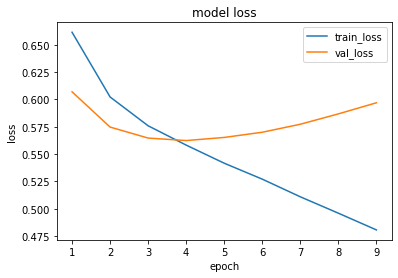

In [72]:
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

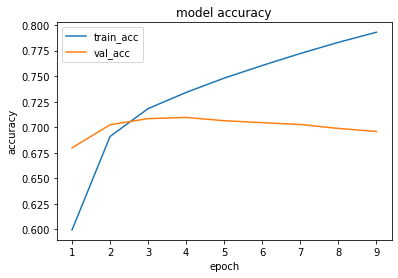

In [73]:
# Accuracy Graph(Training and Validation) 
plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

# Refrence

https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm <br>
https://www.kaggle.com/logoffske/kr-assignment04-sarcasm-detection-with-logit <br>
https://www.kaggle.com/yastapova/sarcasm-detection-2020-mentoring-proj-part-1<br>
https://www.kaggle.com/morkvas/lemmatization-stemming-and-stopwords#Lemmatization,-Stemming-and-StopWords-for-sarcasm-detection<br>
https://www.kaggle.com/prashantkikani/are-you-being-sarcastic-sarcasm-detection-nlp<br>
https://medium.com/analytics-vidhya/sarcasm-detection-with-neural-networks<br>